# Selecting Assets III: Tradable Securities 

In [71]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                          # To access websites.

import os

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

Get price data:

In [72]:
PRICE  = pd.read_csv('data/tiingo/close.csv',    index_col='date', parse_dates=['date'])
RET    = pd.read_csv('data/tiingo/adjClose.csv', index_col='date', parse_dates=['date']).pct_change()  
VOLUME = pd.read_csv('data/tiingo/volume.csv',   index_col='date', parse_dates=['date'])
DOLLAR_VOLUME = VOLUME * PRICE

Get benchmark:

In [73]:
vti = tiingo.get_dataframe(['VTI'], '1990-1-1', metric_name='adjClose')
vti.index = pd.to_datetime(vti.index).tz_convert(None)

Get sales data:

In [74]:
sales = pd.read_csv('data/sec/items/Sales.csv',  parse_dates=['filed'], index_col=['cik','filed'])

Now forward-fill the sales data to all trading days:

In [75]:
def ffill_values(item, dates):                                          
    data = item.unstack('cik')
    data = data.reindex(dates.union(data.index)).sort_index()           # Add specified dates to index.
    filing_dates = pd.read_csv('data/sec/dates/filing_dates.csv', index_col='cik', parse_dates=['filed']).filed
    last_filing_date_all_firms = filing_dates.max()                     # Most recent date where at least 1 firm filed.
     
    for cik in data.columns:                                            # Loop over all firms.
        last_filing_date      = pd.Series(filing_dates[cik]).iloc[-1]   # Last date where this firm filed
        days_since_last_filed = (last_filing_date_all_firms - last_filing_date).days
        last_date_this_firm   = dates[-1] if days_since_last_filed < 120 else last_filing_date
        data.loc[:last_date_this_firm, cik].ffill(inplace=True)         # Forward fill all the values.

    return data.loc[dates]                                              # Return only specified dates.   



trading_days = pd.to_datetime( tiingo.get_dataframe('SPY','2009-04-15').index ).tz_convert(None)

salesQ = ffill_values( sales.valueQ,  trading_days )
salesA = ffill_values( sales.valueA,  trading_days )

Now we need to change the column labels from CIKs to ticker symbols:

In [76]:
symbols = pd.read_csv('data/ticker_symbols/symbols.csv',index_col=0)

SALESQ = salesQ.rename(columns=symbols.ticker)
SALESA = salesA.rename(columns=symbols.ticker)

Backtest function:

In [77]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
        
        assets        = select_assets(start_date)               # Call "select_assets()"  function to get the assets.
        start_weights = select_weights(start_date, assets)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Top ten highest annual sales, equal weight and rebalance quarterly:

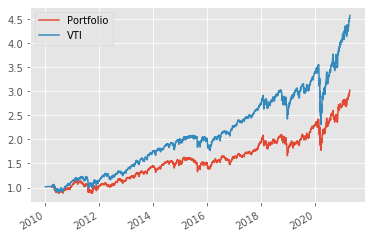

In [78]:
def select_assets(date):
    assets = SALESA[:date].iloc[-1].nlargest(10).index
    return assets


def select_weights(date, assets):            
    return pd.Series(1/len(assets), index=assets)   


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Same strategy for top 100 firms:

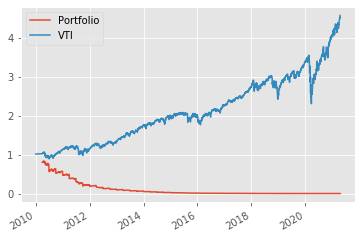

In [79]:
def select_assets(date):
    assets = SALESA[:date].iloc[-1].nlargest(100).index
    return assets


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

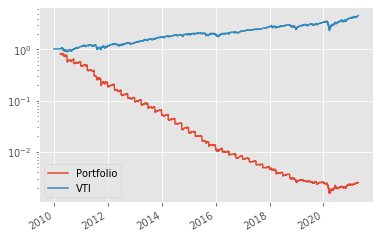

In [80]:
t.add(1).cumprod().plot(logy=True)

Where does all the money go?      

In [81]:
PRICE.columns

Index(['AIR', 'ABT', 'WDDD', 'ACU', 'AE', 'BKTI', 'AMD', 'AEM', 'APD', 'AKZOF',
       ...
       'KVSB', 'TIOAU', 'MSDAU', 'GGPIU', 'NECB', 'HITIF', 'AYRWF', 'OUTR',
       'ABCO', 'NHLDW'],
      dtype='object', length=8170)

In [82]:
SALESA.columns

Index([  'AIR',   'ABT',  'WDDD',    2034,   'ACU',    'AE',  'BKTI',   'AMD',
          2491,   'APD',
       ...
        'CLNN',  'GBNY',  'SPFR',  'POSH',  'WETH', 1827855,  'PLTK',  'FORA',
         'GEG', 'GPACU'],
      dtype='object', name='cik', length=10144)

In [83]:
PRICE.columns.intersection(SALESA.columns)

Index(['AIR', 'ABT', 'WDDD', 'ACU', 'AE', 'BKTI', 'AMD', 'APD', 'CECE', 'MATX',
       ...
       'FHTX', 'CLNN', 'GBNY', 'SPFR', 'POSH', 'WETH', 'PLTK', 'FORA', 'GEG',
       'GPACU'],
      dtype='object', length=5129)

And now restrict our selection to these firms:

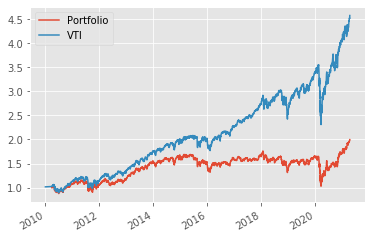

In [84]:
def select_assets(date):
    
    all_firms = PRICE.columns.intersection(SALESA.columns)
    assets = SALESA[all_firms][:date].iloc[-1].nlargest(100).index
    
    return assets


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Example:

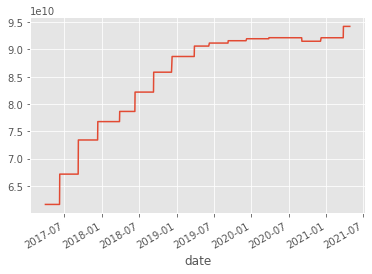

In [85]:
SALESA['DELL'].plot()

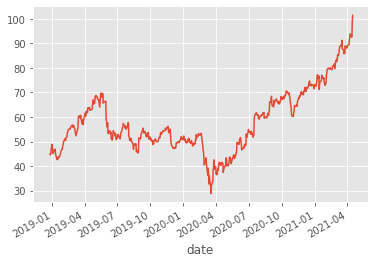

In [86]:
PRICE['DELL'].plot()

In [87]:
all_firms = PRICE.columns.intersection(SALESA.columns)
all_firms

Index(['AIR', 'ABT', 'WDDD', 'ACU', 'AE', 'BKTI', 'AMD', 'APD', 'CECE', 'MATX',
       ...
       'FHTX', 'CLNN', 'GBNY', 'SPFR', 'POSH', 'WETH', 'PLTK', 'FORA', 'GEG',
       'GPACU'],
      dtype='object', length=5129)

In [88]:
'DELL' in all_firms

True

Find all firms that have a price on a specific date:

In [89]:
date = '2017-6-30'

PRICE[all_firms].loc[date]

AIR      34.76
ABT      48.61
WDDD      0.03
ACU      28.60
AE       41.08
         ...  
WETH       NaN
PLTK       NaN
FORA       NaN
GEG        NaN
GPACU      NaN
Name: 2017-06-30 00:00:00, Length: 5129, dtype: float64

In [90]:
PRICE[all_firms].loc[date].dropna()

AIR      34.76
ABT      48.61
WDDD      0.03
ACU      28.60
AE       41.08
         ...  
PRG      38.90
BNTC      1.85
TPL     293.78
FMHS      0.02
HSTA      0.01
Name: 2017-06-30 00:00:00, Length: 4113, dtype: float64

In [91]:
PRICE[all_firms].loc[date].dropna().index

Index(['AIR', 'ABT', 'WDDD', 'ACU', 'AE', 'BKTI', 'AMD', 'APD', 'CECE', 'MATX',
       ...
       'ANAT', 'XPER', 'BLAB', 'HIGR', 'ASRT', 'PRG', 'BNTC', 'TPL', 'FMHS',
       'HSTA'],
      dtype='object', length=4113)

Now try top 100 firms by sales again:

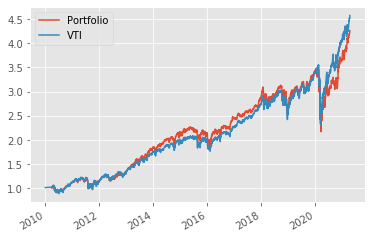

In [92]:
def select_assets(date):
    
    all_firms = PRICE.columns.intersection(SALESA.columns)
    assets_with_price = PRICE[all_firms].loc[date].dropna().index
    assets = SALESA[assets_with_price][:date].iloc[-1].nlargest(100).index
    
    return assets


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()

Small stocks:

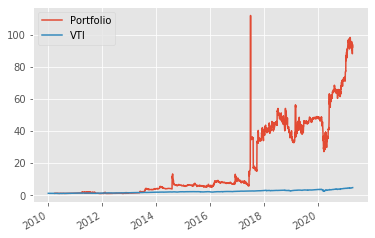

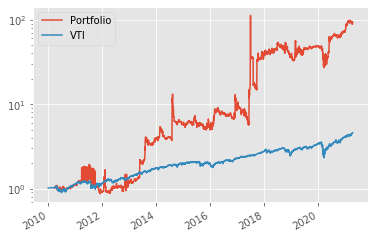

In [93]:
def select_assets(date):
    
    all_firms = PRICE.columns.intersection(SALESA.columns)
    assets_with_price = PRICE[all_firms].loc[date].dropna().index
    assets = SALESA[assets_with_price][:date].iloc[-1].nsmallest(10).index
    
    return assets


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()
t.add(1).cumprod().plot(logy=True)

Check the spike:

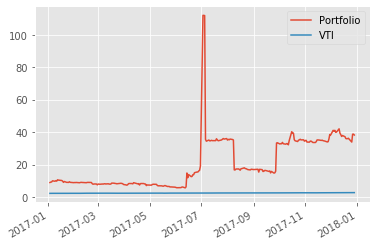

In [94]:
t.add(1).cumprod()['2017'].plot()

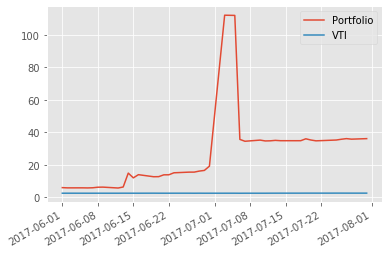

In [95]:
t.add(1).cumprod()['2017-6':'2017-7'].plot()

What stocks are in our portfolio?

In [96]:
weights.loc['2017-7-5'].dropna()

CAG     0.016664
YBAO    0.017069
CHRW    0.017089
LBTI    0.853471
ACFC    0.017222
ICCT    0.017069
PWON    0.017069
LVBX    0.016547
SOWG    0.010729
UGHB    0.017069
Name: 2017-07-05 00:00:00, dtype: float64

In [98]:
PRICE.LBTI['2017-6-1':'2017-7-15']

date
2017-06-01    0.000100
2017-06-02    0.000001
2017-06-05    0.000001
2017-06-06    0.000001
2017-06-07    0.000001
2017-06-08    0.000001
2017-06-09    0.000001
2017-06-12    0.000001
2017-06-13    0.000001
2017-06-14    0.000001
2017-06-15    0.000100
2017-06-16    0.000100
2017-06-19    0.000100
2017-06-20    0.000100
2017-06-21    0.000100
2017-06-22    0.000100
2017-06-23    0.000200
2017-06-26    0.000200
2017-06-27    0.000100
2017-06-28    0.000100
2017-06-29    0.000100
2017-06-30    0.000100
2017-07-03    0.005000
2017-07-05    0.005000
2017-07-06    0.001000
2017-07-07    0.001000
2017-07-10         NaN
2017-07-11         NaN
2017-07-12         NaN
2017-07-13    0.001000
2017-07-14         NaN
Name: LBTI, dtype: float64

In [99]:
x = pd.DataFrame()

x['Price']  = PRICE.LBTI['2017-6':'2017-7']
x['Volume'] = VOLUME.LBTI['2017-6':'2017-7']

x

,Price,Volume
date,,
2017-06-01,0.000100,150.0
2017-06-02,0.000001,931.0
2017-06-05,0.000001,40.0
2017-06-06,0.000001,0.0
2017-06-07,0.000001,0.0
2017-06-08,0.000001,0.0
2017-06-09,0.000001,0.0
2017-06-12,0.000001,0.0
2017-06-13,0.000001,25.0


In [100]:
date = '2017-7-5'

p = PRICE[all_firms].loc[date]
p

AIR      35.30
ABT      49.00
WDDD      0.03
ACU      28.60
AE       41.80
         ...  
WETH       NaN
PLTK       NaN
FORA       NaN
GEG        NaN
GPACU      NaN
Name: 2017-07-05 00:00:00, Length: 5129, dtype: float64

In [101]:
p[p>1]

AIR      35.30
ABT      49.00
ACU      28.60
AE       41.80
BKTI      3.85
         ...  
XPER     33.70
ASRT     11.02
PRG      38.61
BNTC      1.87
TPL     291.77
Name: 2017-07-05 00:00:00, Length: 3289, dtype: float64

In [102]:
'LBTI' in p[p>1].index

False

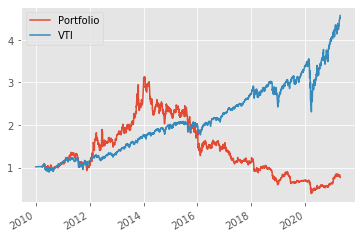

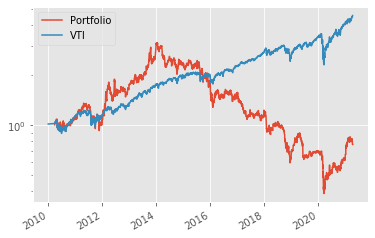

In [104]:
def select_assets(date):
    
    all_firms = PRICE.columns.intersection(SALESA.columns)
    
    p = PRICE[all_firms].loc[date]
    v = DOLLAR_VOLUME[all_firms].loc[date]

    
    min_price = p[p>1].index
    min_volume = v[v>100000].index
    
    tradeable_assets = min_price.intersection(min_volume)
    
    assets = SALESA[tradeable_assets][:date].iloc[-1].nsmallest(10).index
    
    return assets


portfolio, weights, trades = run_backtest('quarter', '2010-1-1')

t = portfolio.to_frame('Portfolio').join(vti.pct_change())
t.add(1).cumprod().plot()
t.add(1).cumprod().plot(logy=True)